# 164992_Fitting+MCMC

Using HD164992 dataset, we demonstrate how to

- perform a max-likelihood fit (with multiple telescopes)
- do an MCMC exploration of the posterior space (with multiple telescopes)


In [1]:
# Preliminary imports
#%pylab osx
%matplotlib inline
import radvel
import radvel.likelihood
import radvel.plotting
import copy
import pandas as pd
import os
from scipy import optimize
import corner
from astropy.time import Time
import numpy as np
from numpy import *
import copy

/Users/bfulton/Ureka/variants/common/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [2]:
def bin_same_night(rv):
    rv['date'] = pd.Series(Time(rv.t,format='jd', scale='utc').iso).str.slice(stop=10)
    rv_mean = rv.groupby('date',as_index=False).mean()
    rv_n = rv.groupby('date',as_index=False).size()
    print len(rv_n),len(rv_mean)
    rv_mean['errvel'] = rv_mean['errvel'] / np.array(np.sqrt(rv_n))
    return rv_mean

path = os.path.join(radvel.DATADIR,'164922.hdf')
rv_hires_rk = pd.read_hdf(path,'hires_rk')
rv_hires_rj = pd.read_hdf(path,'hires_rj')
rv_apf = pd.read_hdf(path,'apf')

rv_hires_rj = bin_same_night(rv_hires_rj)
rv_hires_rk = bin_same_night(rv_hires_rk)
rv_apf = bin_same_night(rv_apf)

t_start = rv_hires_rk.iloc[0]['t']
t_stop = rv_apf.iloc[-1]['t']
ti = linspace(t_start,t_stop,10000)

122 122
51 51
68 68


In [3]:
#Some conveinence functions
def initialize_model():
    time_base = 2456778
    params = radvel.RVParameters(2,basis='per tc secosw sesinw logk')
    params['per1'] = 1201.1 + 0.4
    params['tc1'] = 2456778 + 1
    params['secosw1'] = 0.01 
    params['sesinw1'] = 0.01
    params['logk1'] = 1
    params['per2'] = 75.765 + 0.1
    params['tc2'] = 2456277.6
    params['secosw2'] = 0.01
    params['sesinw2'] = 0.01
    params['logk2'] = 1
    params['dvdt'] = 0
    params['curv'] = 0
    mod = radvel.RVModel(params, time_base=time_base)
    return mod

def plot_results(like,color,label):
    fig = gcf()
    axL = fig.get_axes()
    jit = exp(like.params[like.logjit_param])
    yerr = np.sqrt(like.yerr**2 + jit**2)
    bjd0 = 2450000

    sca(axL[0])
    errorbar(
        like.x-bjd0, like.model(like.x)+like.residuals(), 
        yerr=yerr, fmt='o',color=color,label=label
        )
    plot(ti-bjd0, like.model(ti))
    fig.set_tight_layout(True)
    sca(axL[1])
    errorbar(
        like.x-bjd0, like.residuals(), 
        yerr=yerr, fmt='o'
        )


# Max-likelihood fitting

1. Initialize model
2. Build up likelihoods
3. Instantiate posterior
4. Perform fit

In [4]:
def initialize_likelihood(rv,suffix):
    like = radvel.likelihood.RVLikelihood( 
        mod, rv.t, rv.vel, rv.errvel,suffix=suffix)
    return like
mod = initialize_model()

# Build up HIRES >2004 likelihood
like_hires_rj = initialize_likelihood(rv_hires_rj,'_hires_rj')
like_hires_rj.params['gamma_hires_rj'] = 1.0
like_hires_rj.params['logjit_hires_rj'] = np.log(1)

# Build up HIRES <2004 likelihood
like_hires_rk = initialize_likelihood(rv_hires_rk,'_hires_rk')
like_hires_rk.params['gamma_hires_rk'] = 1.0
like_hires_rk.params['logjit_hires_rk'] = np.log(1)

# Build up APF
like_apf = initialize_likelihood(rv_apf,'_apf')
like_apf.params['gamma_apf'] = 1.0
like_apf.params['logjit_apf'] = np.log(1)

# Build composite likelihood
like = radvel.likelihood.CompositeLikelihood(
    [like_hires_rj,like_hires_rk,like_apf])

# Set initial values for jitter
like.params['logjit_hires_rk'] = log(2.6)
like.params['logjit_hires_rj'] = log(2.6)
like.params['logjit_apf'] = log(2.6)

# Do not vary dvdt or jitter (Fulton 2015)
like.vary['dvdt'] = False
like.vary['curv'] = False
like.vary['logjit_hires_rk'] = False
like.vary['logjit_hires_rj'] = False
like.vary['logjit_apf'] = False

In [5]:
# Instantiate posterior
post = radvel.posterior.Posterior(like)
post0 = copy.deepcopy(post)

# Add in priors
post.priors += [radvel.prior.EccentricityPrior( 2 )] # Keeps eccentricity < 1

# Perform Max-likelihood fitting
res  = optimize.minimize(
    post.neglogprob_array,
    post.get_vary_params(), 
    method='Powell',
    options=dict(maxiter=100000,maxfev=100000,xtol=1e-8)
    )


print "Initial loglikelihood = %f" % post0.logprob()
print "Final loglikelihood = %f" % post.logprob()
print post

Initial loglikelihood = -738.412567
Final loglikelihood = -588.766863
parameter                          value       vary
curv                                   0      False
dvdt                                   0      False
gamma_apf                        1.03764       True
gamma_hires_rj                  0.264434       True
gamma_hires_rk                  0.194238       True
logjit_apf                      0.955511      False
logjit_hires_rj                 0.955511      False
logjit_hires_rk                 0.955511      False
logk1                            1.97723       True
logk2                            0.83706       True
per1                             1201.38       True
per2                               75.77       True
secosw1                        -0.232674       True
secosw2                        0.0522802       True
sesinw1                         0.283472       True
sesinw2                         0.471026       True
tc1                          2.45678e+06      

## Make a nice plot

In [12]:
,close all
fig,axL = subplots(nrows=2,figsize=(12,8),sharex=True)
plot_results(like.like_list[0],'black','hires_rj') # plot best fit model
plot_results(like.like_list[1],'Tomato','hires_rk') # plot best fit model
plot_results(like.like_list[2],'RoyalBlue','apf') # plot best fit model
axL[0].legend()
bjd0 = 2450000
xlabel('BJD_TBD - %i' % bjd0)
ylabel('RV')
[ax.grid() for ax in axL]
draw()

NameError: name 'close' is not defined

# Perform MCMC posterior exploration

In [ ]:
# Only use one thread!
df = radvel.mcmc(post,threads=1,nburn=1000,nwalkers=40,nrun=1000)

In [ ]:
df_cps = post.params.basis.to_cps(df)
labels = 'per1 tc1 e1 k1 per2 tc2 e2 k2 gamma_hires_rj gamma_hires_rk gamma_apf '.split()
df_cps[labels].quantile([0.14,0.5,0.84]).T

Compare with parameters from fulton et al. (2016)
---------

In [ ]:
,close all
labels = 'per1 tc1 e1 k1 per2 tc2 e2 k2 gamma_hires_rj gamma_hires_rk gamma_apf '.split()
rc('font',size=8)
dims = len(labels)
fig,axL = subplots(nrows=dims,ncols=dims,figsize=(10,10))
corner_kw = dict(
    labels=labels,
    levels=[0.68,0.95],
    plot_datapoints=False,
    smooth=True,
    bins=20,
    )
corner.corner(df_cps[labels],fig=fig,**corner_kw)

Planet 1
Planet 2


/Users/bfulton/Ureka/python/lib/python2.7/site-packages/matplotlib-1.3.1-py2.7-macosx-10.6-x86_64.egg/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


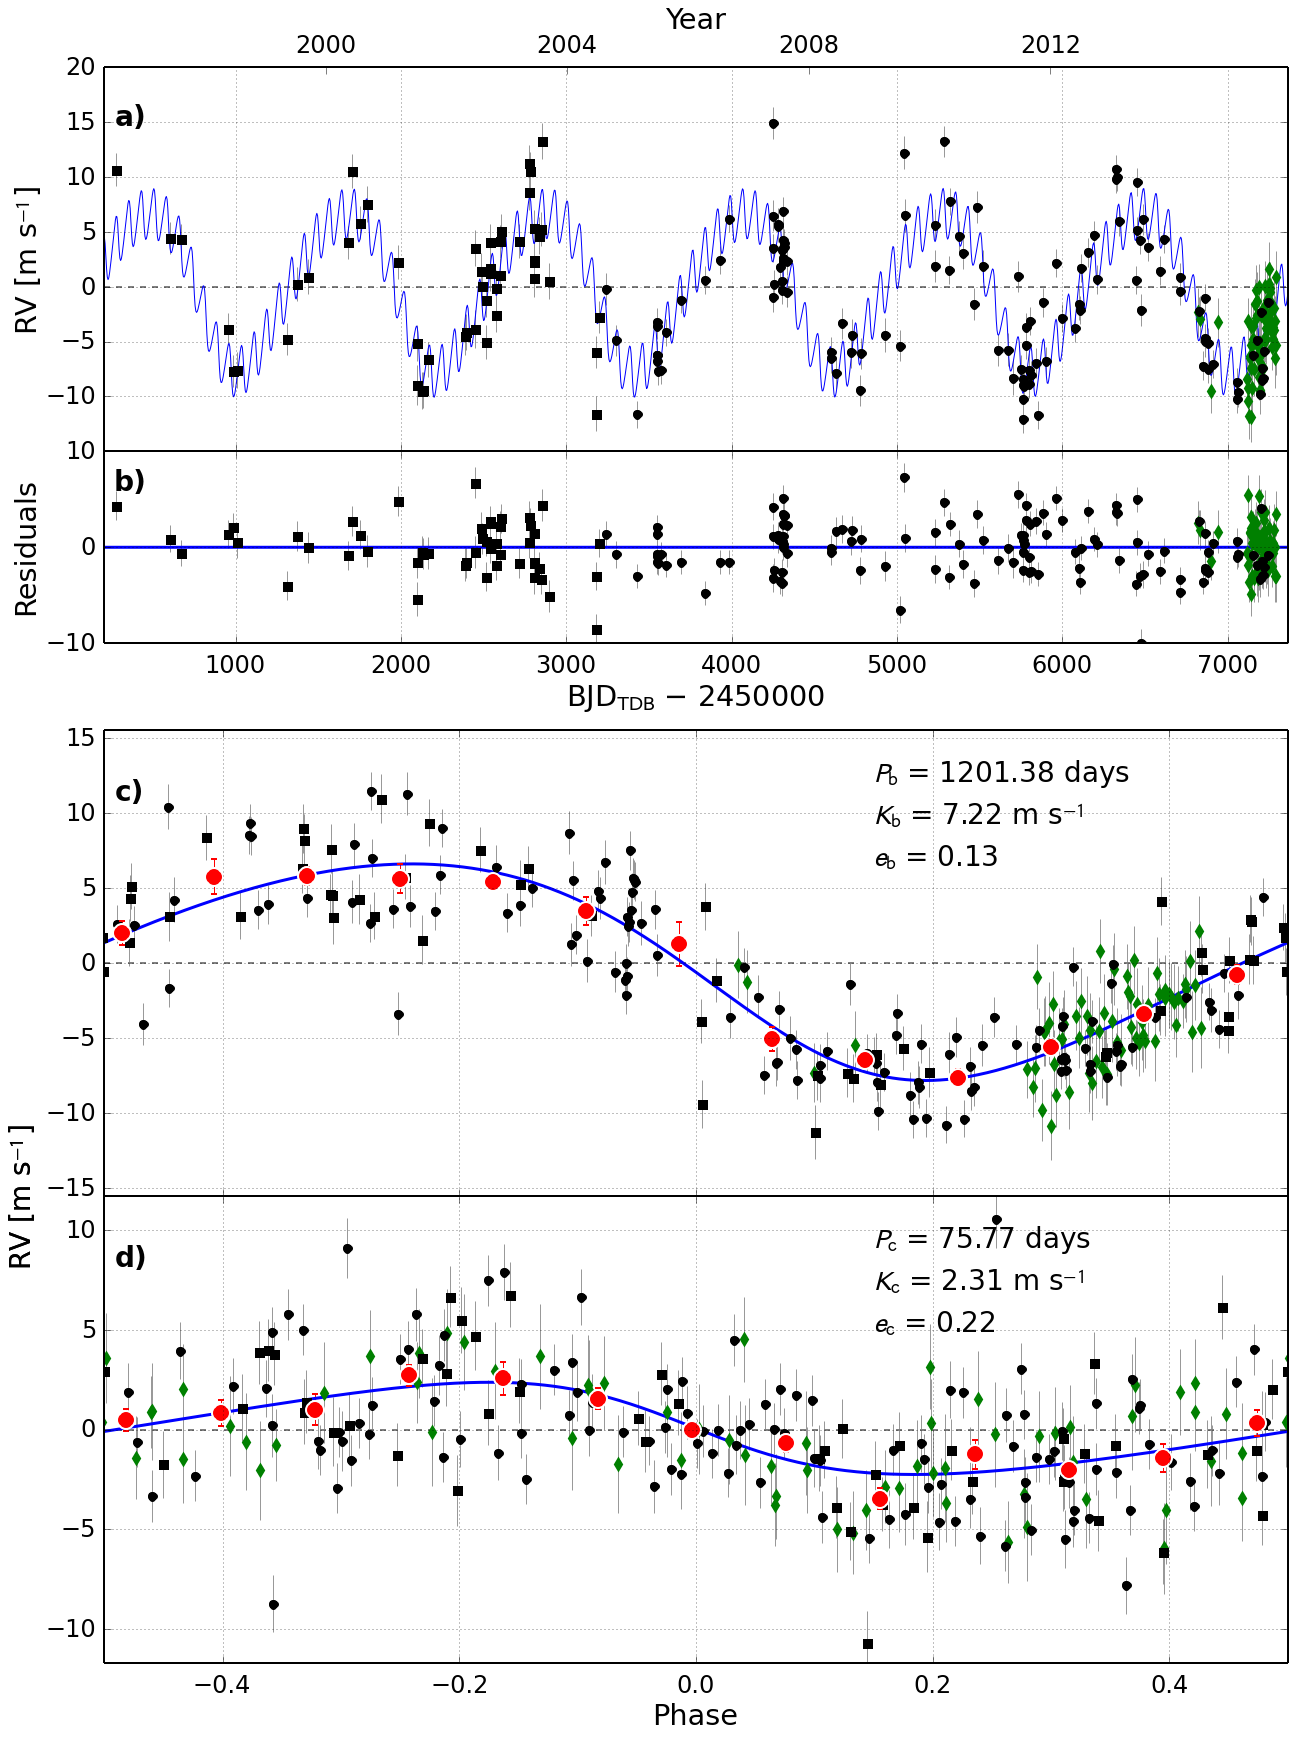

In [6]:
radvel.plotting.rv_multipanel_plot(post)